# Prevención Fuga de Clientes
El enfoque de la prevención es disminuir el impacto latente de la posibilidad de que alguno de los clientes deje de comprar productos. 
Con este fin se realiza la estrategia en 3 sentidos: <br>
**1.Motor de Recomendación** <br>
**Objetivo:** Aumentar la penetración de los productos a los clientes con el fin de fortalecer la relación comercial y su fidelización. <br>
Este enfoque hace parte de la primera parte del notebook, con el objetivo de generar un motor de recomendación con el cual se facilite la venta de nuevos productos por medio de estrategia de datos. <br>
*Notebook 1: Motor de recomendación* <br>

**2.Nueva segmentación de información con base en los datos de los clientes y sus transacciones** <br>
**Objetivo:** Generar nueva información de los clientes, con el objetivo de realizar una mejor gestión de estos y plantear estrategias con base en esta nueva característica de información desarrollada. <br>
El segundo enfoque es a través de una nueva segmentación, que permita de igual forma identificar no solo como y que es posible comprar, sino generar nuevas dimensiones de análisis, para que los equipos de business intelligence, comerciales y financieros, tengan más herramientas durante sus estrategias de negocio. <br>
*Notebook 2: Segmentación de datos* <br>

**3.Predecir la Fuga de clientes** <br>
**Objetivo:** Desarrollar un marcaje de fuga de clientes con base en la historia transaccional de cliente, permitiendo esto entrenar un modelo de Machine Learning para predecir la posible baja de clientes. <br>
El Tercer enfoque tiene dos frentes de trabajo, el primero permite establecer a través de variables de tendencias de compra y montos, si el cliente se encuentra "vivo" o no. Con base en este resultado, se activa el segundo frente, el cual a través de algoritmos de Machine Learning permite predecir la fuga de clientes con base en el marcaje realizado en la primera etapa. <br>
*Notebook 3: Predicción Fuga Clientes* <br>


### Fuente de datos
Los datos usando durante la tesis son de dominio publico y hacen referencia a un comercio de Brasil. <br>
Estos datos han sido modelados en un modelo dimensional con el fin de mejorar el performance del análisis del actual tesis y permitir generar modelos de reporting/dashboard con herramientas de BI.<br>
Los datos han sido migrados a la plataforma github con el fin que sean de dominio publico. <br>


## 3.Predicción Fuga de Clientes
Una vez se han implementado todas las estrategias de retención de clientes, es necesario conocer cuales de estos se pueden ir, con el fin de que los equipos de fidelización puedan evitar que esta perdida suceda. <br>
Para ello es necesario abordarse en dos enfoques:

*   El primero centrado a identificar cuales de estos clientes ya definitivamente son bajas en la organización, utilizando los datos como fuente predominante para esta marcación, ya que actualmente no se cuenta con esta data.
*  Como sigueinte paso, una vez , identificado quienes son marcados como churn, se procede a obtener este input, con el fin de entrenar  algoritmos de machine learning supervisado que nos permitan predecir la fuga de estos clientes y seleccionar el que de un mejor resultado. 



### 3.1 Carga de librerias y datos

In [0]:
#!pip install lifetimes

# librerias requeridas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import preprocessing
from google.colab import files
from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions, plot_cumulative_transactions,plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive


## metodos de selección
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

## machine larning
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.svm import SVC as svc 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
import graphviz 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

##

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Using TensorFlow backend.


In [0]:
## Localización y carga de los datos
url = 'https://github.com/masdatascience/TFM-AI/blob/master/data_model_completo.xlsx?raw=true'
datos_modelo = pd.ExcelFile(url)
datos_facturacion = pd.read_excel(datos_modelo, sheet_name='fac_txn')
print("Datos cargados Facturación:"+str(datos_facturacion.shape))
datos_producto = pd.read_excel(datos_modelo, sheet_name='product')
print("Datos cargados Productos:"+str(datos_producto.shape))
datos_clientes = pd.read_excel(datos_modelo, sheet_name='customer')
print("Datos cargados Clientes:"+str(datos_clientes.shape))
print(datos_producto.shape)

Datos cargados Facturación:(112650, 21)
Datos cargados Productos:(32951, 10)
Datos cargados Clientes:(96352, 4)
(32951, 10)


### 3.2 Preparación de los datos 
En esta sección se estarán depurando los datos y generando las funciones requeridas para este capitulo

#### 3.2.1 Limpieza de datos



In [0]:
# Se elimian los datos nulos de las dimensiones importantes del analisis que son productos y clientes
datos_facturacion = datos_facturacion.dropna(subset=['customer_id'])
datos_facturacion = datos_facturacion.dropna(subset=['product_id'])
# Se elimina posibles chargeback que se presenten
datos_facturacion = datos_facturacion.loc[datos_facturacion['total_value'] > 0]
datos_facturacion = datos_facturacion.loc[datos_facturacion['num_txn'] > 0]
# se eliminan posibles ordenes duplicadas
datos_facturacion.drop_duplicates('order_id',keep='first',inplace=True)
# se convierte la fecha de compra en tipo date con el fin de realizar comprobaciones de tiempo desde dia y no, dia-hora
datos_facturacion['date'] = pd.to_datetime(datos_facturacion['order_purchase_timestamp']).dt.date
datos_facturacion = datos_facturacion.drop('order_purchase_timestamp',axis=1)


#### 3.2.2 Se definen funciones de clustering

In [0]:
# Se define una función que grafica el codo para identificar la mejor agrupación

def metodo_codo(datos):

  dataset =  datos.iloc[:, :].values
  estandar = StandardScaler()
  dataset= estandar.fit_transform(dataset)
  resultados = [] 
  # Se realizan una revisión de las primeras 10 agrupaciones
  for i in range(1,11): 
      kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
      kmeans.fit(dataset)
      resultados.append(kmeans.inertia_)
  plt.plot(range(1,11) , resultados,'ro-', markersize=8, lw=2)
  plt.title('Metodo del codo')
  plt.xlabel('Número de agrupaciones de clientes')
  plt.ylabel('WCSS')
  plt.show()
 

 
 

## 3.3 Marcar Clientes Perdidos
En este capitulo se realizará el marcaje de los clientes que se den como perdidos, con base en el comportamiento de compras, frecuencia y montos , a través de aplicar el modelo RFM



### 3.3.1 Modelo RFM

Este modelo utiliza tres variables iniciales para medir al cliente :


*   Recencia (Recency): Se puede clasificar esto en la cantida de dias sin compras
*   Frecuencia (Frecuency): Cuantas veces ha comprado,  Más de 5 veces, Entre 2 y 4 o solo 1 vez
*   Valor Monetario (Monetary): Su costo , Más de 100 USD, Entre 50 y 99 USD o Menos de 50 USD

In [0]:
# se realiza un subconjunto de columnas con los cuales se analizará el comportamiento de compra
transaction_data = datos_facturacion[['customer_id','date','total_value']]
# se crea el modelo RFM
modelo_rfm = summary_data_from_transaction_data(transaction_data,'customer_id','date',monetary_value_col='total_value',)

Los datos que obtenemos del modelo RFM son :

*   **Frecuencia**: Representa el número de compras repetidas que ha realizado el cliente. Esto significa, que es el recuento de períodos en los que el cliente realizó una compra. Por lo tanto, si usa días como unidades, entonces es el recuento de días en que el cliente realizó una compra.
*   **T**: Tepresenta la edad del cliente en las unidades de tiempo elegidas  Esto es igual a la duración entre la primera compra de un cliente y el final del período
*   **Recencia**:Es el tiempo que ha pasado desde su última compra. Esto es igual a la duración entre la primera compra de un cliente y su última compra. (Por lo tanto, si solo han realizado 1 compra, la antigüedad es 0.)

Por lo Anterior descrito, podemos definir una hipotesis en donde si la Recencia es inferior a 1 , su Frecuencia es inferior a 1 , ya podemos tener una referencia de un posible Churn. Para proponer un valor para T , se utiliza la siguiente visualización de un mapa de calor, en donde se indica en amarillo los clientes que estan vivos y en morado los que no. 




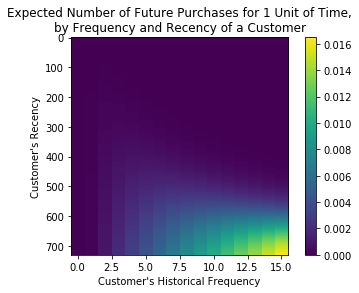

In [0]:
# Se comprueba como es el comportamiento de los clientes
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(modelo_rfm['frequency'], modelo_rfm['recency'], modelo_rfm['T'])
plot_frequency_recency_matrix(bgf);

### 3.3.2 Definición y aplicación de hipotesis con RFM
Con base en este resultado se pueden proponer la siguiente hiporesis de marcaje de clientes perdidos:

1.   **Frecuencia**: Cualquier cliente que tenga una Frencuencia inferior a 1 
2.   **T**: Se observa que a nivel 400 en adelante los valores se encuentra morados
3.   **Recencia**: Por su misma formula, todo lo que sea inferior a 1 , se puede marcar como churn

In [0]:
# Se aplica la hipotesis 
modelo_rfm['churn'] = np.where( (modelo_rfm['frequency']<1) & (modelo_rfm['T']>400) & (modelo_rfm['recency']<1), 1, 0) 
# Se integra esta caracteristicas a los clienes
datos_clientes = pd.merge(datos_clientes,modelo_rfm[['churn']],on='customer_id', how='left').fillna(0)
print("Datos actualizados de Clientes:"+str(datos_clientes.shape))
print("Se identifica que el porcentaje de clientes de baja es: "+str(round(datos_clientes.churn.mean(),2)*100)+"%")

Datos actualizados de Clientes:(96352, 5)
Se identifica que el porcentaje de clientes de baja es: 18.0%


## 3.4 Predecir perdida de Clientes
En este capitulo con los clientes marcados como perdidos, se procede a realizar una serie de pruebas, de integración de nuevas variables con los clientes , como tambien de tecnicas de codificación que permitan generar mejorar resultados a los algoritmos a ser utilizados. <br>
Como alcance de estos algoritmos se implementaran los siguienes:

*   Random Forest
*   Regresión lineal
*   Gradient Boosting Classifier
*   Support Vector Machine
*   Redes neuronales



### 3.4.1 Definición de funciones


In [0]:
# Random Forest
def randomForest():
  print("-------------------------------------------------------------------------------")
  print("En ejecución algoritmo de Random Forest")
  rfc_object = rfc(n_estimators=200, random_state=0)
  rfc_object.fit(train_features, train_labels)
  predicted_labels = rfc_object.predict(test_features)
  # se verifican resultados
  print(classification_report(test_labels, predicted_labels))
  print(confusion_matrix(test_labels, predicted_labels))
  print(accuracy_score(test_labels, predicted_labels))

  # Regresión lineal
def regresionLineal():
  print("-------------------------------------------------------------------------------")
  print("En ejecución algoritmo de Regresión lineal")
  # Algoritmo
  lr_object = LogisticRegression()
  lr_object.fit(train_features, train_labels)
  predicted_labels = lr_object.predict(test_features)
  # se verifican resultados
  print(classification_report(test_labels, predicted_labels))
  print(confusion_matrix(test_labels, predicted_labels))
  print(accuracy_score(test_labels, predicted_labels))
  
  
#Gradient Boosting Classifier
def gradientBoost():
  print("-------------------------------------------------------------------------------")
  print("En ejecución algoritmo de Gradient Boosting Classifier")
  gb = GradientBoostingClassifier()
  gb.fit(train_features, train_labels)
  predicted_labels = gb.predict(test_features)
  # se verifican resultados
  print(classification_report(test_labels, predicted_labels))
  print(confusion_matrix(test_labels, predicted_labels))
  print(accuracy_score(test_labels, predicted_labels))
  
# SVM  
def SVM():
  print("-------------------------------------------------------------------------------")
  print("En ejecución algoritmo de Support Vector Machine")
  scaling = MinMaxScaler(feature_range=(-1,1)).fit(train_features)
  X_train = scaling.transform(train_features)
  svc_object = svc(kernel='rbf', degree=8)
  svc_object.fit(X_train, train_labels)
  predicted_labels = svc_object.predict(test_features) 
  # se verifican resultados
  print(classification_report(test_labels, predicted_labels))
  print(confusion_matrix(test_labels, predicted_labels))
  print(accuracy_score(test_labels, predicted_labels))

# Redes neuronales
def redesNeuronales():
  print("-------------------------------------------------------------------------------")
  print("En ejecución algoritmo de Redes Neuronales")
  # Se genera el modelo 
  modelo = Sequential()
  #Se define un monitor de parada temprana para que el modelo deje de entrenar cuando ya no mejore
  early_stopping_monitor = EarlyStopping(patience=3)
  #Se obtienen las columnas de entrenamiento
  scale = StandardScaler()
  X_dataset = scale.fit_transform(datos)
  Y_dataset =clase.values 
  n_cols = X_dataset.shape[1]
  #Se agregan las capas, aumentar el número de nodos en cada capa aumenta la capacidad del modelo pero por Collab lo dejare en esa cantidad
  modelo.add (Dense (128, activation = 'relu', input_shape = (n_cols,))) 
  modelo.add( Dropout(0.3))
  modelo.add (Dense (64, activation = 'relu')) 
  modelo.add( Dropout(0.25))
  modelo.add (Dense (64, activation = 'sigmoid')) 
  modelo.add( Dropout(0.4))
  modelo.add (Dense (64, activation = 'sigmoid')) 
  modelo.add( Dropout(0.25))
  modelo.add (Dense (1, activation = 'sigmoid')) 
  modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  resultado=modelo.fit(X_dataset, Y_dataset, batch_size=30, epochs=30, validation_split=0.4, callbacks=[early_stopping_monitor])
  # se verifican resultados
  predicted_labels = modelo.predict(test_features)
  print(classification_report(test_labels, predicted_labels.round()))
  print(confusion_matrix(test_labels, predicted_labels.round()))
  print(accuracy_score(test_labels, predicted_labels.round()))
  
    
  # Se tienen dos tipos horizontal (H) o Vertical (V)
  def codificacion(datos, campo, tipo):
      if tipo == 'V':
          enconder = LabelEncoder()
          datos[campo]= enconder.fit_transform(datos[campo])
          return  datos
      elif modelo == 'H':
          col_vertical = pd.get_dummies(datos.campo).iloc[:,1:]
          datos =  datos.drop([campo], axis=1)
          datos =  pd.concat([datos,col_vertical], axis=1)
          return datos
      else : 
          print("ERROR: Verifique el tipo de solicitud")


### 3.4.2 Completar información de Clientes
El objetivo de este enfoque es mejorar la data que se le puede entregar a los algoritmos con el fin de encontrar las caracteristicas claves de información que pueden ser utilizar 


### 3.4.3 Enfoque de la ejecución de los algoritmos

El dataset de clientes, tiene cinco (5) caracteristicas definidas : customer_id, customer_state, customer_city, customer_zip_code_prefix y churn. Con lo se puede realizar el entrenamiento directo con los algoritmos de Machine Learning definidos . <br>
De igual forma, se tienen relaciones que impactan en la relacion con el cliente, como son los productos comprados, vendedores, entre otros, los cuales se han integrado en un dataset adicional denominado como transacciones del cliente, con el fin de integrarlos en una segunda validación , e identificar su impacto en el churn del cliente. Sus nuevas caracteristicas son seis (6) :  order_id, seller_id, product_id, order_status, date, price.

In [0]:
url_txn = 'https://github.com/masdatascience/TFM-AI/blob/master/customer_txn.xlsx?raw=true'
datos_txn = pd.ExcelFile(url_txn)
datos_clientes_txn = pd.read_excel(datos_txn, sheet_name='customer_txn')
# Se elimian los datos nulos de las dimensiones importantes del analisis que son productos y clientes
datos_clientes_txn = datos_clientes_txn.dropna(subset=['customer_id'])
datos_clientes_txn = datos_clientes_txn.dropna(subset=['product_id'])
# Se elimina posibles chargeback que se presenten
datos_clientes_txn = datos_clientes_txn.loc[datos_clientes_txn['price'] > 0]
# se integran los campos originales de los clientes 
datos_clientes_txn=pd.merge(datos_clientes_txn,datos_clientes,on='customer_id', how='left')

#### 3.4.3.1 Funciones de selección de variables
Se estarán identificando los mejores 4  y 5 variables para entrenar a los algoritmos, para ello, se definen los siguientes metodos de selección de caracteristicas, a ser utilizadas para obtener las más relevantes: 

1.   Importancia de la característica con Extra Trees
2.   Selección univariante
3.   Eliminación de características recursivas
4.   PCA 


In [0]:
def sel_EXT(datos, clase, num_variables):
  # Se aplica el metodo
  model = ExtraTreesClassifier()
  model.fit(datos, clase)
  # Se imprimen resultados
  print("Metodo: Importancia de la característica con Extra Trees")
  print(model.feature_importances_)


def sel_univariante(datos, clase, num_variables):
  # Se aplica el metodo
  test = SelectKBest(score_func=chi2, k=num_variables)
  fit = test.fit(datos, clase)
  # Se imprimen resultados
  print("Metodo: Selección univariante")
  np.set_printoptions(precision=3)
  print(fit.scores_)
  features = fit.transform(datos)
  print(str(features[0:5,:]))

  
def sel_recursiva(datos, clase, num_variables):
    # Se aplica el metodo  
    model = LogisticRegression(solver="liblinear", multi_class="auto")
    rfe = RFE(model, num_variables)
    fit = rfe.fit(datos, clase)
    # Se imprimen resultados
    print("Metodo: Eliminación de características recursivas")
    print("Ranking de caracteristicas en su posición en los datos:"+ str(fit.ranking_))
    #print("Se identifican los siguientes features:" +str(clientes_cod.drop('churn',axis=1).columns[fit.support_]))  

def sel_PCA(datos, clase, num_variables):
    # Se aplica el metodo  
    pca = PCA(n_components=num_variables)
    fit = pca.fit(datos)
    # Se imprimen resultados
    print("Metodo: PCA")
    print("Resultado de las varianzas: " +  str(fit.explained_variance_ratio_))
    print("Resultado de la evaluació de los componentes:")
    print(fit.components_) 

#### 3.4.3.2 Selección de variables dataset clientes transaccional
Se aplican los diferentes metodos de selección de variables con agrupaciones de cuatro caracteristicas. Con los resultados obtenidos entre los diferentes metodos, se procederá a seleccionar las caracteristicas relevantes

In [0]:
# Se transforman los valores categoricos a númericos
clientes_cod = datos_clientes_txn.drop('customer_id',axis=1)
enconder = LabelEncoder()
clientes_cod['seller_id'] = enconder.fit_transform(clientes_cod['seller_id'])
clientes_cod['product_id'] = enconder.fit_transform(clientes_cod['product_id'])
clientes_cod['order_status'] = enconder.fit_transform(clientes_cod['order_status'])
clientes_cod['customer_city'] = enconder.fit_transform(clientes_cod['customer_city'])
clientes_cod['customer_state'] = enconder.fit_transform(clientes_cod['customer_state'])
clientes_cod['DATE'] = enconder.fit_transform(clientes_cod['DATE'])
# Se definen los datos de caracteristicas y el clasificador de churn 
datos = clientes_cod.drop(['churn'],axis=1)
clase = clientes_cod.churn
print("Orden de las columnas:")
datos.dtypes

Orden de las columnas:


seller_id                   int64
product_id                  int64
order_status                int64
DATE                        int64
price                       int64
customer_state              int64
customer_city               int64
customer_zip_code_prefix    int64
dtype: object

##### 3.4.3.2.1 Enfoque cuatro variables y todas las caracteristicas de información

In [0]:
# Se inicia identificando las 4 más importantes
sel_EXT(datos,clase,4)
sel_univariante(datos,clase,4)
sel_recursiva(datos,clase,4)
sel_PCA(datos,clase,4)
# Orden Columnas
#1:seller_id', 2:'product_id', 3:'order_status', 4:'DATE', 5:'price', 6:'customer_state', 7:'customer_city', 8:'customer_zip_code_prefix'

Metodo: Importancia de la característica con Extra Trees
[0.03438217 0.03113858 0.00275334 0.83789057 0.03211228 0.00798275
 0.02193538 0.03180492]
Metodo: Selección univariante
[4.813e+04 7.666e+04 5.730e+00 3.425e+06 1.073e+05 1.006e+02 7.266e+03
 2.512e+06]
[[ 8628   264  5890 28013]
 [29597   124 23990 15775]
 [25667   387 19900 35661]
 [15322   593  1299 12952]
 [22079    43 19990 13226]]
Metodo: Eliminación de características recursivas
Ranking de caracteristicas en su posición en los datos:[1 3 1 1 5 1 2 4]
Metodo: PCA
Resultado de las varianzas: [0.666 0.266 0.067 0.001]
Resultado de la evaluació de los componentes:
[[-9.656e-05  7.972e-04  5.751e-08 -2.489e-04  4.517e-02 -1.043e-04
  -1.259e-02  9.989e-01]
 [ 8.456e-04  8.574e-03  1.132e-07  7.094e-06  9.989e-01 -4.669e-06
  -5.709e-05 -4.517e-02]
 [ 5.345e-04 -1.000e+00  2.328e-07  2.228e-04  8.601e-03  1.968e-06
   4.266e-04  4.147e-04]
 [ 2.537e-04 -4.371e-04 -2.234e-07 -1.119e-04 -6.223e-04 -8.187e-04
  -9.999e-01 -1.258e-

Como resultado de la priorización de las cuatro (4) variables más relevante, se obtiene la siguiente información:



*   **Importancia de la característica con Extra Trees**: Identificó las siguientes caracteristicas como relevantes: **DATE, seller_id, product_id, price, customer_zip_code_prefix**. Las últimas tres variables tuvieron el mismo valor por eso no se da un resultado de 4 valores.
*   **Selección Univariante**: Identificó las siguientes caracteristicas como relevantes: **order_status, customer_state, customer_city, seller_id**
*   **Eliminación de características recursivas**: Identificó las siguientes caracteristicas como relevantes: **seller_id, order_status, DATE, customer_state**
*   **PCA**: Identificó las siguientes caracteristicas como relevantes: **customer_zip_code_prefix, customer_city, price, product_id**


Como conclusión las más relevantes, según el número de veces que aparezcan en los diferentes metodos son:

1.   seller_id : Aparece en tres resultados
2.   order_status: Aparece en dos resultados, en un ranking de 1ro y 2do
3.   DATE:  Aparece en dos resultados, en un ranking de 1ro y 3ro
4.   customer_zip_code_prefix: Aparece en dos resultados, en un ranking de  1ro y 4to 
5.  product_id: Aparece en dos resultados, en un ranking de 3ro y 4to
6.  price: Aparece en dos resultaods, en un ranking de 3ro y 4to
7.  customer_city: Aparece en dos resultados, en un ranking de 3ro y 2do
8.  customer_state: Aparece en dos resultados, en un ranking de 2do y 4to

Como resultado, se hace un ranking con base en el número de repeticiones, y si en alguna de ellas quedo de primero, de esto, se concluye que los cuatro campos claves para este experimento son *seller_id, order_status, DATE, customer_zip_code_prefix*




##### 3.4.3.2.2 Enfoque cuatro variables y descartando al tiempo en el dataset

In [0]:
# Se elimina DATE
datos = datos.drop(['DATE'],axis=1)
# Se aplican los metodos
sel_EXT(datos,clase,4)
sel_univariante(datos,clase,4)
sel_recursiva(datos,clase,4)
sel_PCA(datos,clase,4)
# Orden Columnas
#1:seller_id', 2:'product_id', 3:'order_status', 4:'price', 5:'customer_state', 6:'customer_city', 7:'customer_zip_code_prefix'

Metodo: Importancia de la característica con Extra Trees
[0.218 0.213 0.006 0.223 0.022 0.107 0.21 ]
Metodo: Selección univariante
[4.813e+04 7.666e+04 5.730e+00 1.073e+05 1.006e+02 7.266e+03 2.512e+06]
[[  854  8628  5890 28013]
 [ 2678 29597 23990 15775]
 [ 1117 25667 19900 35661]
 [ 1919 15322  1299 12952]
 [ 2697 22079 19990 13226]]
Metodo: Eliminación de características recursivas
Ranking de caracteristicas en su posición en los datos:[1 2 1 4 1 1 3]
Metodo: PCA
Resultado de las varianzas: [0.666 0.266 0.067 0.001]
Resultado de la evaluació de los componentes:
[[-9.656e-05  7.972e-04  5.751e-08  4.517e-02 -1.043e-04 -1.259e-02
   9.989e-01]
 [ 8.456e-04  8.574e-03  1.132e-07  9.989e-01 -4.669e-06 -5.709e-05
  -4.517e-02]
 [ 5.345e-04 -1.000e+00  2.328e-07  8.601e-03  1.968e-06  4.266e-04
   4.146e-04]
 [ 2.533e-04 -4.370e-04 -2.236e-07 -6.223e-04 -8.187e-04 -9.999e-01
  -1.258e-02]]


Como resultado de la priorización de las cuatro (4) variables más relevante, se obtiene la siguiente información:

*   **Importancia de la característica con Extra Trees**: Identificó las siguientes caracteristicas como relevantes: **price, seller_id, product_id, customer_state, customer_zip_code_prefix**. Las últimas tres variables tuvieron el mismo valor por eso no se da un resultado de 4 valores.
*   **Selección Univariante**: Identificó las siguientes caracteristicas como relevantes: **order_status, customer_state, customer_city, product_id**
*   **Eliminación de características recursivas**: Identificó las siguientes caracteristicas como relevantes: **seller_id, order_status, customer_state, customer_city**
*   **PCA**: Identificó las siguientes caracteristicas como relevantes: **customer_zip_code_prefix, customer_city, price, product_id**


Como conclusión las más relevantes, según el número de veces que aparezcan en los diferentes metodos son:

1.   product_id: Aparece en tres resultados 
2.   customer_state: Aparece en tres resultados 
3.   seller_id : Aparece en en dos resultados, en un ranking de 1ro y 2do
4.   order_status: Aparece en dos resultados, en un ranking de 1ro y 2do
5.   customer_zip_code_prefix: Aparece en dos resultados, en un ranking de 1ro y 2do
6.   price: Aparece en dos resultaods, en un ranking de 1ro y 3ro
7.   customer_city: Aparece en dos resultados, en un ranking de 3ro y 2do

Como resultado, se hace un ranking con base en el número de repeticiones, y si en alguna de ellas quedo de primero; de esto, se concluye que los cuatro campos claves para este experimento son *product_id, customer_state, seller_id, order_status*


### 3.4.4 Ejecución de Experimentos
En este capitulo, se ejecutaron los algoritmos con el fin de identificar cual es el que mejor da resultados, como tambien poner a prueba las dos agrupaciones priorizadas de variables

#### 3.4.4.1 Ejecución de algoritmos con conjunto 1 de caracteristicas priorizadas

In [0]:
# Se define el primer conjunto de caracteristicas priorizadas 
grupo1 = ['seller_id', 'order_status', 'DATE', 'customer_zip_code_prefix']

# Enfoque 
datos = clientes_cod.loc[:, grupo1] 
clase = clientes_cod.churn
# Se realiza los subconjunto de datos para entrenamiento y pruebas 
train_features, test_features, train_labels, test_labels = train_test_split(datos, clase, test_size=0.3, random_state=1)
# Ejecuto algoritmos
randomForest()
regresionLineal()
gradientBoost()
SVM()
redesNeuronales()
print("Fin de la ejecución de los algoritmos")


-------------------------------------------------------------------------------
En ejecución algoritmo de Random Forest
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     25380
         1.0       0.95      1.00      0.98      5529

    accuracy                           0.99     30909
   macro avg       0.98      0.99      0.99     30909
weighted avg       0.99      0.99      0.99     30909

[[25110   270]
 [    7  5522]]
0.9910382089359087
-------------------------------------------------------------------------------
En ejecución algoritmo de Regresión lineal
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     25380
         1.0       0.87      0.58      0.70      5529

    accuracy                           0.91     30909
   macro avg       0.89      0.78      0.82     30909
weighted avg       0.91      0.91      0.90     30909

[[24911   469]
 [ 2301  3228]]
0.9103820893590864
---

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 61816 samples, validate on 41212 samples
Epoch 1/30
61816/61816 [==============================] - 7s 108us/step - loss: 0.0964 - acc: 0.9647 - val_loss: 0.0559 - val_acc: 0.9817
Epoch 2/30
61816/61816 [==============================] - 6s 93us/step - loss: 0.0582 - acc: 0.9819 - val_loss: 0.0533 - val_acc: 0.9827
Epoch 3/30
61816/61816 [==============================] - 5s 89us/step - loss: 0.0540 - acc: 0.9835 - val_loss: 0.0530 - val_acc: 0.9822
Epoch 4/30
61816/61816 [==============================] - 6s 90us/step - loss: 0.0522 - acc: 0.9846 - val_loss: 0.0455 - val_acc: 0.9882
Epoch 5/30
61816/61816 [==============================] - 5s 84us/step - loss: 0.0515 - acc: 0.9846 - val_loss: 0.0475 - val_acc: 0.9860
Epoch 6/30
61816/61816 [==============================] - 5s 87us/step - loss: 0.0501 - acc: 0.9853 - val_loss: 0.0443 - val_acc: 0.9886
Epoch 7/30
61816/61816 [=======

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### 3.4.4.2 Ejecución de algoritmos con conjunto 2 de caracteristicas priorizadas

In [0]:
# Se define el segundo conjunto de caracteristicas priorizadas 
grupo2 = ['product_id', 'customer_state', 'seller_id', 'order_status']

# Enfoque 
datos = clientes_cod.loc[:, grupo2] 
clase = clientes_cod.churn
# Se realiza los subconjunto de datos para entrenamiento y pruebas 
train_features, test_features, train_labels, test_labels = train_test_split(datos, clase, test_size=0.3, random_state=1)
# Ejecuto algoritmos
randomForest()
regresionLineal()
gradientBoost()
SVM()
redesNeuronales()

-------------------------------------------------------------------------------
En ejecución algoritmo de Random Forest
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90     25380
         1.0       0.54      0.30      0.39      5529

    accuracy                           0.83     30909
   macro avg       0.70      0.62      0.64     30909
weighted avg       0.80      0.83      0.81     30909

[[23967  1413]
 [ 3864  1665]]
0.8292730272736096
-------------------------------------------------------------------------------
En ejecución algoritmo de Regresión lineal


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90     25380
         1.0       0.00      0.00      0.00      5529

    accuracy                           0.82     30909
   macro avg       0.41      0.50      0.45     30909
weighted avg       0.67      0.82      0.74     30909

[[25380     0]
 [ 5529     0]]
0.8211200621178297
-------------------------------------------------------------------------------
En ejecución algoritmo de Gradient Boosting Classifier
              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90     25380
         1.0       0.74      0.01      0.02      5529

    accuracy                           0.82     30909
   macro avg       0.78      0.50      0.46     30909
weighted avg       0.81      0.82      0.74     30909

[[25365    15]
 [ 5487    42]]
0.8219935940988061
-------------------------------------------------------------------------------
En ejecución algoritmo de Suppo

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90     25380
         1.0       0.00      0.00      0.00      5529

    accuracy                           0.82     30909
   macro avg       0.41      0.50      0.45     30909
weighted avg       0.67      0.82      0.74     30909

[[25380     0]
 [ 5529     0]]
0.8211200621178297
-------------------------------------------------------------------------------
En ejecución algoritmo de Redes Neuronales
Train on 61816 samples, validate on 41212 samples
Epoch 1/30
61816/61816 [==============================] - 6s 94us/step - loss: 0.4678 - acc: 0.8259 - val_loss: 0.4702 - val_acc: 0.8201
Epoch 2/30
61816/61816 [==============================] - 5s 85us/step - loss: 0.4639 - acc: 0.8259 - val_loss: 0.4702 - val_acc: 0.8201
Epoch 3/30
61816/61816 [==============================] - 5s 86us/step - loss: 0.4630 - acc: 0.8259 - val_loss: 0.4703 - val_acc: 0.8201
Epoch 4/30
61816/61816 [===============

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### 3.4.4.3 Ejecución de algoritmossin caracteristicas priorizadas

In [0]:
# Se define el segundo conjunto de caracteristicas priorizadas 

# Enfoque 
datos = clientes_cod.drop('churn',axis=1) 
clase = clientes_cod.churn
# Se realiza los subconjunto de datos para entrenamiento y pruebas 
train_features, test_features, train_labels, test_labels = train_test_split(datos, clase, test_size=0.3, random_state=1)
# Ejecuto algoritmos
randomForest()
regresionLineal()
gradientBoost()
SVM()
redesNeuronales()

-------------------------------------------------------------------------------
En ejecución algoritmo de Random Forest
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     25380
         1.0       0.95      1.00      0.98      5529

    accuracy                           0.99     30909
   macro avg       0.98      0.99      0.98     30909
weighted avg       0.99      0.99      0.99     30909

[[25102   278]
 [    4  5525]]
0.9908764437542463
-------------------------------------------------------------------------------
En ejecución algoritmo de Regresión lineal
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     25380
         1.0       0.89      0.81      0.85      5529

    accuracy                           0.95     30909
   macro avg       0.93      0.89      0.91     30909
weighted avg       0.95      0.95      0.95     30909

[[24843   537]
 [ 1056  4473]]
0.9484616131223915
---

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90     25380
         1.0       0.00      0.00      0.00      5529

    accuracy                           0.82     30909
   macro avg       0.41      0.50      0.45     30909
weighted avg       0.67      0.82      0.74     30909

[[25380     0]
 [ 5529     0]]
0.8211200621178297
-------------------------------------------------------------------------------
En ejecución algoritmo de Redes Neuronales
Train on 61816 samples, validate on 41212 samples
Epoch 1/30
61816/61816 [==============================] - 6s 100us/step - loss: 0.1037 - acc: 0.9610 - val_loss: 0.0597 - val_acc: 0.9809
Epoch 2/30
61816/61816 [==============================] - 6s 89us/step - loss: 0.0662 - acc: 0.9780 - val_loss: 0.0642 - val_acc: 0.9761
Epoch 3/30
61816/61816 [==============================] - 6s 89us/step - loss: 0.0580 - acc: 0.9815 - val_loss: 0.0497 - val_acc: 0.9855
Epoch 4/30
61816/61816 [==============

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogReg| Mean=0.948247 STD=0.001912
DecTree| Mean=0.980044 STD=0.001354
LinDisc| Mean=0.983422 STD=0.001469
Gradiente| Mean=0.989488 STD=0.001414
RandomForest| Mean=0.989779 STD=0.001230
GaussianNB| Mean=0.973017 STD=0.001288


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

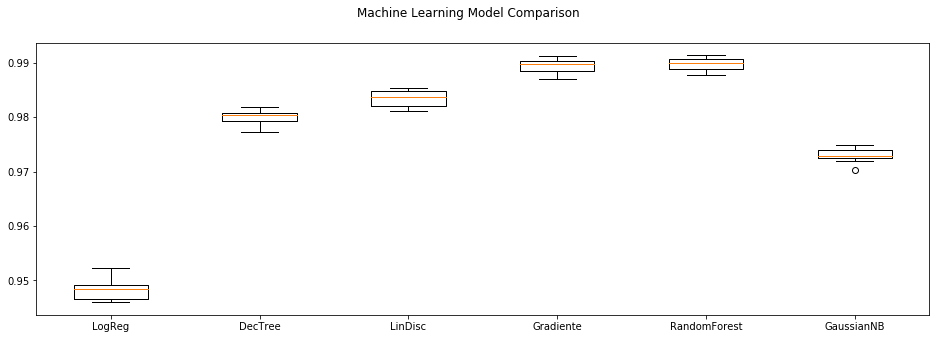

In [0]:
X= datos
Y = clase

outcome = []
model_names = []
models = [('LogReg', LogisticRegression()), 
          #('SVM', SVC()), 
          ('DecTree', DecisionTreeClassifier()),
          #('KNN', KNeighborsClassifier()),
          ('LinDisc', LinearDiscriminantAnalysis()),
          ('Gradiente', GradientBoostingClassifier()),
          ('RandomForest', rfc(n_estimators=200, random_state=0)),          
          ('GaussianNB', GaussianNB())]


  

for model_name, model in models:
    k_fold_validation = model_selection.KFold(n_splits=10, random_state=1)
    results = model_selection.cross_val_score(model, X, Y, cv=k_fold_validation, scoring='accuracy')
    outcome.append(results)
    model_names.append(model_name)
    output_message = "%s| Mean=%f STD=%f" % (model_name, results.mean(), results.std())
    print(output_message)

fig = plt.figure()
fig.suptitle('Machine Learning Model Comparison')
fig.set_size_inches(12, 5)
ax = fig.add_subplot(111)
plt.boxplot(outcome)
ax.set_xticklabels(model_names)
plt.show()

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn import ensemble, linear_model, neighbors, svm, tree, neural_network
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm,model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    #ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    #linear_model.PassiveAggressiveClassifier(),
    #linear_model. RidgeClassifierCV(),
    #linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    #svm.SVC(probability=True),
    #svm.NuSVC(probability=True),
    #svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
   #tree.ExtraTreeClassifier(),
    
    ]

MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)


row_index = 0
for alg in MLA:
    
    
    predicted = alg.fit(train_features, train_labels).predict(test_features)
    fp, tp, th = roc_curve(test_labels, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Train Accuracy'] = round(alg.score(train_features, train_labels), 4)
    MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(alg.score(test_features, test_labels), 4)
    MLA_compare.loc[row_index, 'MLA Precission'] = precision_score(test_labels, predicted)
    MLA_compare.loc[row_index, 'MLA Recall'] = recall_score(test_labels, predicted)
    MLA_compare.loc[row_index, 'MLA AUC'] = auc(fp, tp)


 


    row_index+=1
    
MLA_compare.sort_values(by = ['MLA Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

In [0]:
plt.subplots(figsize=(15,6))
sns.barplot(x="MLA Name", y="MLA Train Accuracy",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('MLA Train Accuracy Comparison')
plt.show()

In [0]:
plt.subplots(figsize=(15,6))
sns.barplot(x="MLA Name", y="MLA Test Accuracy",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('MLA Test Accuracy Comparison')
plt.show()

In [0]:
plt.subplots(figsize=(15,6))
sns.barplot(x="MLA Name", y="MLA Precission",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('MLA Precission Comparison')
plt.show()

In [0]:
plt.subplots(figsize=(15,6))
sns.barplot(x="MLA Name", y="MLA Recall",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('MLA Recall Comparison')
plt.show()

In [0]:
plt.subplots(figsize=(15,6))
sns.barplot(x="MLA Name", y="MLA AUC",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('MLA AUC Comparison')
plt.show()

In [0]:
index = 1
for alg in MLA:
    
    
    predicted = alg.fit(x_train, y_train).predict(x_test)
    fp, tp, th = roc_curve(y_test, predicted)
    roc_auc_mla = auc(fp, tp)
    MLA_name = alg.__class__.__name__
    plt.plot(fp, tp, lw=2, alpha=0.3, label='ROC %s (AUC = %0.2f)'  % (MLA_name, roc_auc_mla))
   
    index+=1

plt.title('ROC Curve comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')    
plt.show()

### 3.4.5 Análisis y resultados de los experimentos


Como resultado de los experimentos, se puede denotar que los metodos más efectivos para este tipo de información son los algoritmos de **Random Forest y Gradient Boosting Classifier**, ya que han sido los mejores, con los grupo 1, grupo2 y la totalidad de los datos.  

*   **Resultado 1**: Random Forest: 99,10%    -  Gradient Boosting Classifier: 98,98%
*   **Restulado 2**: Random Forest: 82,92%    -  Gradient Boosting Classifier: 82,19%
*   **Restulado 3**: Random Forest: 99,08%    -  Gradient Boosting Classifier: 98,98%

